In [1]:
from glotaran_tools.specification_parser import parse_yml
from glotaran_core.model import Dataset
from glotaran_models.kinetic import KineticSeperableModel
import numpy as np
from lmfit import Parameters
# Imports for plotting

import matplotlib.pyplot as plt
%matplotlib notebook

test_parameter = [101e-4, 1, 10]
test_amps = [1,2,3]
times = np.asarray(np.arange(-50, 1500, 1.5))

fitspec = '''
type: kinetic

parameter: {}

compartments: [s1, s2, s3]

megacomplexes:
    - label: mc1
      k_matrices: [k1]
      
k_matrices:
  - label: "k1"
    matrix: {{
      '("s1","s1")': 1,
}}

irf:
  - label: irf1
    type: gaussian
    center: 2
    width: 3
datasets: 
  - label: dataset1
    type: spectral
    megacomplexes: [mc1]
    path: 'data/dataset1.ascii'
    irf: irf1

'''
model = parse_yml(fitspec.format(test_parameter))
print(model)

Modeltype: Kinetic

Parameter
---------

Index: 1 Initial Value: 0.0101 Label: None
Index: 2 Initial Value: 1.0 Label: None
Index: 3 Initial Value: 10.0 Label: None

Megacomplexes
-------------

Label: mc1
K-Matrices: ['k1']

Datasets
--------

Dataset 'dataset1'

	Dataset Scaling: None
	Initial Concentration: None
	Megacomplexes: ['mc1']

	Irf: irf1


K-Matrices
----------

Label: k1
Matrix:
[[1]]


IRFs
----

Label: irf1 Type: 'Gaussian' Center: [2] Width: [3] Center Dispersion: [] Width Dispersion [] Scale: [], Nomalize: True



In [2]:
simparams = Parameters()
simparams.add("p1", 301e-5)
#simparams.add("p2",802e-5)
#simparams.add("p3",505e-5)
simparams.add("p2",0.3)
simparams.add("p3",21.4)
simparams.pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr
p1   0.00301     -inf      inf     None     True     None
p2       0.3     -inf      inf     None     True     None
p3      21.4     -inf      inf     None     True     None


In [3]:
fitmodel = KineticSeperableModel(model)
fitmodel.get_initial_fitting_parameter().pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr
p1    0.0101     -inf      inf     None     True     None
p2         1     -inf      inf     None     True     None
p3        10     -inf      inf     None     True     None


<IPython.core.display.Javascript object>


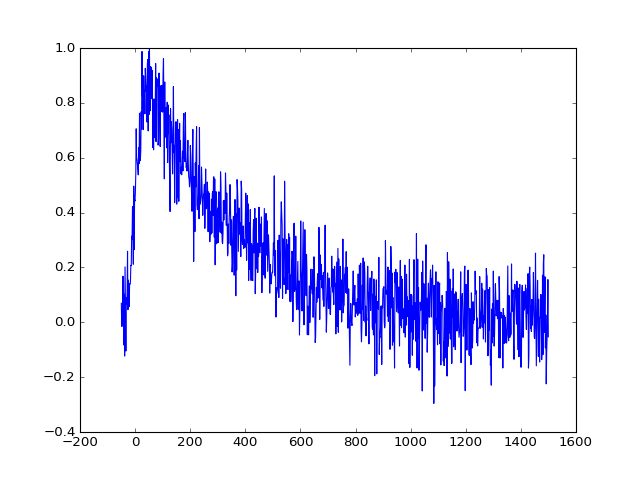

In [4]:
data = fitmodel.eval(simparams, *times, **{'dataset':'dataset1', 'noise':True, 'noise_std_dev':0.1})

fig = plt.figure()
plt.plot(times, data[:, 0])

In [5]:
result = fitmodel.fit(fitmodel.get_initial_fitting_parameter(), 
                      *times, 
                      **{"data": data}
                     )
result.best_fit_parameter.pretty_print()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.2164e+01                                    2.02e+03    
       1              3         1.6298e+01      5.87e+00       9.92e-01       1.41e+04    
       2              4         6.8757e+00      9.42e+00       9.92e-01       3.69e+03    
       3              5         5.5076e+00      1.37e+00       1.98e+00       3.71e+02    
       4              6         5.3366e+00      1.71e-01       3.97e+00       2.59e+01    
       5              7         5.2606e+00      7.60e-02       5.67e+00       1.33e+01    
       6              8         5.2599e+00      7.31e-04       5.34e-01       2.56e-02    
       7              9         5.2599e+00      1.87e-07       8.15e-03       8.58e-04    
       8             10         5.2599e+00      1.59e-10       2.97e-04       2.13e-05    
`ftol` termination condition is satisfied.
Function evaluations 10, initial cost 2.2164e+0

Fitted Amplitudes: [[ 0.99868658]]


<IPython.core.display.Javascript object>


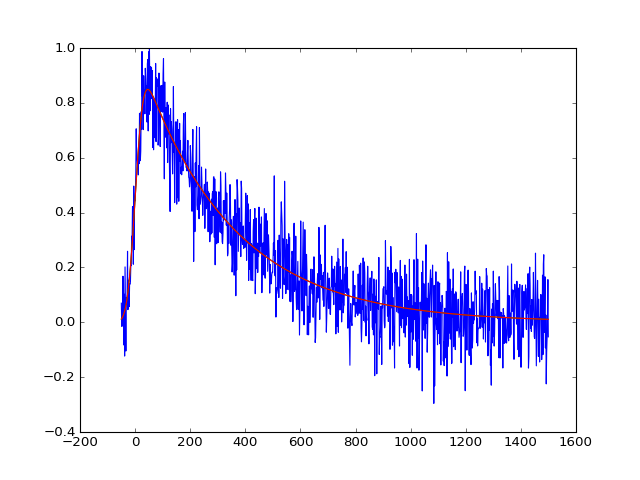

(1034, 1)
(1034, 1)


In [6]:
fitted_data = fitmodel.eval(result.best_fit_parameter, *times, **{'dataset':'dataset1'})
reconstructed_data = result.eval(*times, **{"data": data})
print('Fitted Amplitudes: {}'.format(result.e_matrix(*times, **{"data": data})))

fig = plt.figure()
plt.plot(times, data[:, 0])
plt.plot(times, fitted_data[:, 0])
plt.plot(times, reconstructed_data[:, 0])